# Importing Libraries


In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
from scipy.fft import fft2, ifft2, fftshift

# Gaussian noise

In [ ]:
# Function to add Gaussian noise to an image
def add_gaussian_noise(image, mean=0, sigma=0.1):
    """
    Add Gaussian noise to an image.

    Parameters:
    image (numpy.ndarray): The input image to which noise will be added.
    mean (float): The mean of the Gaussian noise distribution. Default is 0.
    sigma (float): The standard deviation of the Gaussian noise distribution. Default is 0.1.

    Returns:
    numpy.ndarray: The noisy image with Gaussian noise added.
    """

    gaussian_noise = np.random.normal(mean, sigma, image.shape)
    noisy_image = np.clip(image + gaussian_noise, 0, 1)
    return noisy_image

# Salt and Pepper noise

In [ ]:
# Function to add salt and pepper noise to an image
def add_salt_and_pepper_noise(image, salt_pepper_ratio=0.5, amount=0.02):
    """
    Add salt and pepper noise to an image.

    Parameters:
    image (numpy.ndarray): The input image to which noise will be added.
    salt_pepper_ratio (float): Ratio of salt (white) to pepper (black) noise. Default is 0.5.
    amount (float): The proportion of image pixels to replace with noise. Default is 0.02.

    Returns:
    numpy.ndarray: The noisy image with salt and pepper noise added.
    """

    noisy_image = np.copy(image)
    num_salt = np.ceil(amount * image.size * salt_pepper_ratio)
    num_pepper = np.ceil(amount * image.size * (1.0 - salt_pepper_ratio))

    # Add Salt (white) noise
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy_image[tuple(coords)] = 1

    # Add Pepper (black) noise
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy_image[tuple(coords)] = 0

    return noisy_image

# k-space truncation

In [ ]:
# Function to perform k-space truncation
def k_space_truncation(image, truncation_factor):
    """
    Perform k-space truncation on an image.

    Parameters:
    image (numpy.ndarray): The input image to be transformed.
    truncation_factor (int): The factor determining the size of the central region in k-space to keep.

    Returns:
    numpy.ndarray: The transformed image after applying k-space truncation.
    """

    k_space = np.fft.fftshift(np.fft.fft2(image))
    mask = np.zeros_like(k_space)
    center_x, center_y = mask.shape[0] // 2, mask.shape[1] // 2
    mask[center_x-truncation_factor//2:center_x+truncation_factor//2,
         center_y-truncation_factor//2:center_y+truncation_factor//2] = 1
    truncated_k_space = k_space * mask
    truncated_image = np.abs(np.fft.ifft2(np.fft.ifftshift(truncated_k_space)))
    return truncated_image

# Image Augmentation

In [ ]:
# Function to perform image augmentation
def augment_image(image, num_augmentations=4):
    """
    Apply various augmentations to an image based on specified parameters.

    Parameters:
    image (numpy.ndarray): The input image to be augmented.
    augmentation_params (dict): A dictionary containing parameters and settings for different augmentations.

    Returns:
    numpy.ndarray: The augmented image.
    """

    # Define augmentation sequence
    seq = iaa.Sequential([
        iaa.Affine(rotate=(-10, 10), scale=(0.8, 1.2)),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.GaussianBlur(sigma=(0, 0.5)),
        # Add more augmentations as needed
    ])

    # Apply augmentation multiple times
    augmented_images = [seq(image=image) for _ in range(num_augmentations)]
    return augmented_images

# Image Generation

In [ ]:
# Function to generate low-quality and noisy images for each augmented image
def generate_low_quality_and_noisy(augmented_images, truncation_factor=26, noise_sigma=0.05, salt_pepper_ratio=0.5, salt_pepper_amount=0.02):
    """
    Generate a low-quality and noisy version of the input image.

    Parameters:
    image (numpy.ndarray): The original, high-quality image.
    noise_params (dict): Parameters defining the type and amount of noise to add to the image.
    quality_params (dict): Parameters defining how to reduce the quality of the image (e.g., compression, resolution reduction).

    Returns:
    numpy.ndarray: The modified image that is both lower in quality and has added noise.
    """

    low_quality_images = []
    noisy_images = []
    salt_pepper_noisy_images = []

    for augmented_image in augmented_images:
        # Apply k-space truncation
        low_res_image = k_space_truncation(augmented_image, truncation_factor)
        low_quality_images.append(low_res_image)

        # Add Gaussian noise
        gaussian_noisy_image = add_gaussian_noise(low_res_image, sigma=noise_sigma)
        noisy_images.append(gaussian_noisy_image)

        # Add salt-and-pepper noise
        sp_noisy_image = add_salt_and_pepper_noise(low_res_image, salt_pepper_ratio, salt_pepper_amount)
        salt_pepper_noisy_images.append(sp_noisy_image)

    return low_quality_images, noisy_images, salt_pepper_noisy_images

# Selecting Folder Paths

In [ ]:
# Folder containing images
folder_path = '/content/images_folder'

In [ ]:
# Output folder
output_folder = '/content/output'
os.makedirs(output_folder, exist_ok=True)

# Reading all images in the folder

In [ ]:
# Get all file names in the folder
image_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))]


# Function calls

In [ ]:
# Initialize lists to store augmented, low-quality, and noisy images
all_original_images = []
all_augmented_images = []
all_low_quality_images = []
all_noisy_images = []
salt_pepper_noisy_images = []

In [ ]:
# Process each input image
for image_path in image_paths:
    # Load the original image
    original_image = np.array(Image.open(image_path).convert('L')) / 255.0
    all_original_images.append(original_image)

    # Generate augmented images
    augmented_images = augment_image(original_image)

    # Generate low-quality, Gaussian noisy, and salt-and-pepper noisy images for each augmented image
    low_quality_images, gaussian_noisy_images, sp_noisy_images = generate_low_quality_and_noisy(augmented_images)

    # Append to the overall lists
    all_augmented_images.extend(augmented_images)
    all_low_quality_images.extend(low_quality_images)
    all_noisy_images.extend(gaussian_noisy_images)
    salt_pepper_noisy_images.extend(sp_noisy_images)


# Exporting Images

In [ ]:
# Display the images
num_images = len(image_paths)
num_augmentations = 4

In [ ]:
for i in range(len(all_original_images)):

    # Save original image with nearest neighbor interpolation
    original_path = os.path.join(output_folder, f'original_image_{i + 1}.png')
    Image.fromarray((all_original_images[i] * 255).astype(np.uint8)).save(original_path)

    for j in range(num_augmentations):
        # Save augmented image with nearest neighbor interpolation
        augmented_path = os.path.join(output_folder, f'augmented_image_{i + 1}_{j + 1}.png')
        Image.fromarray((all_augmented_images[i * num_augmentations + j] * 255).astype(np.uint8), mode='L').save(augmented_path, resample=Image.NEAREST)

        # Save low-quality image with nearest neighbor interpolation
        low_quality_path = os.path.join(output_folder, f'low_quality_image_{i + 1}_{j + 1}.png')
        Image.fromarray((all_low_quality_images[i * num_augmentations + j] * 255).astype(np.uint8), mode='L').save(low_quality_path, resample=Image.NEAREST)

        # Save Gaussian noisy image with nearest neighbor interpolation
        gaussian_noisy_path = os.path.join(output_folder, f'gaussian_noisy_image_{i + 1}_{j + 1}.png')
        Image.fromarray((all_noisy_images[i * num_augmentations + j] * 255).astype(np.uint8), mode='L').save(gaussian_noisy_path, resample=Image.NEAREST)

        # Save Salt-and-Pepper noisy image with nearest neighbor interpolation
        sp_noisy_path = os.path.join(output_folder, f'salt_pepper_noisy_image_{i + 1}_{j + 1}.png')
        Image.fromarray((salt_pepper_noisy_images[i * num_augmentations + j] * 255).astype(np.uint8), mode='L').save(sp_noisy_path, resample=Image.NEAREST)


print("All images saved successfully.")

All images saved successfully.


# Individual Section Comparisons

Image Augmentation Comparisons

In [ ]:
# Function to display individual images with headings
def display_individual_images(images, headings, figsize=(15, 8)):
    """
    Display a series of images individually with optional titles.

    Parameters:
    images (list of numpy.ndarray): A list of images to be displayed.
    titles (list of str, optional): A list of titles corresponding to each image. If provided, each image will be displayed with its respective title.

    Returns:
    None: This function does not return anything but displays the images on the screen.
    """

    num_images = len(images)
    plt.figure(figsize=figsize)

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(headings[i])
        plt.axis('off')

    plt.show()

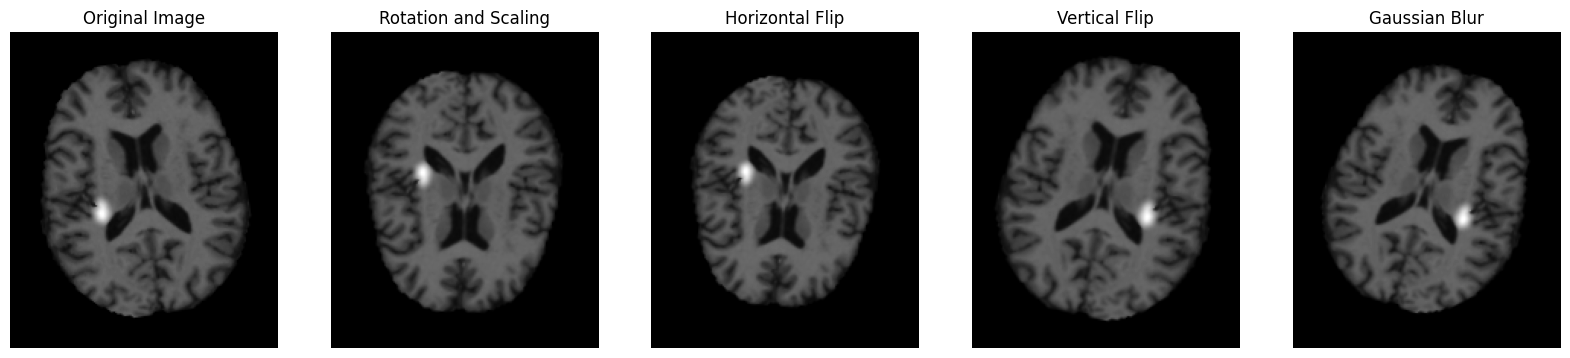

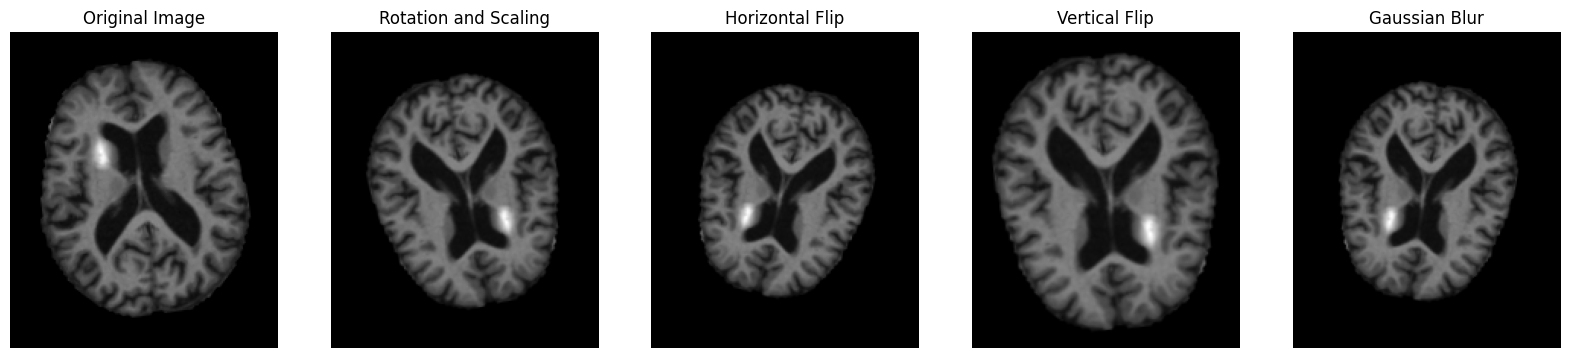

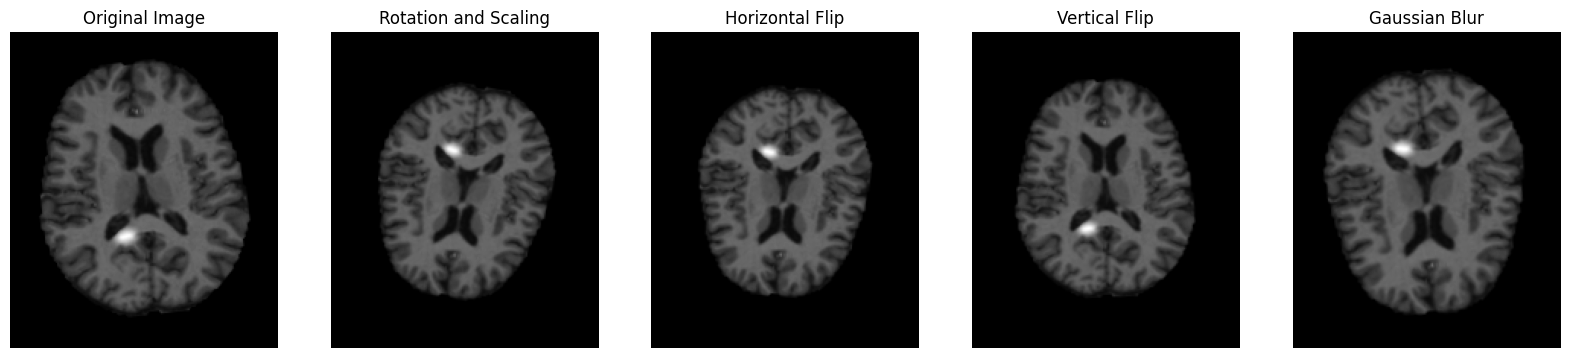

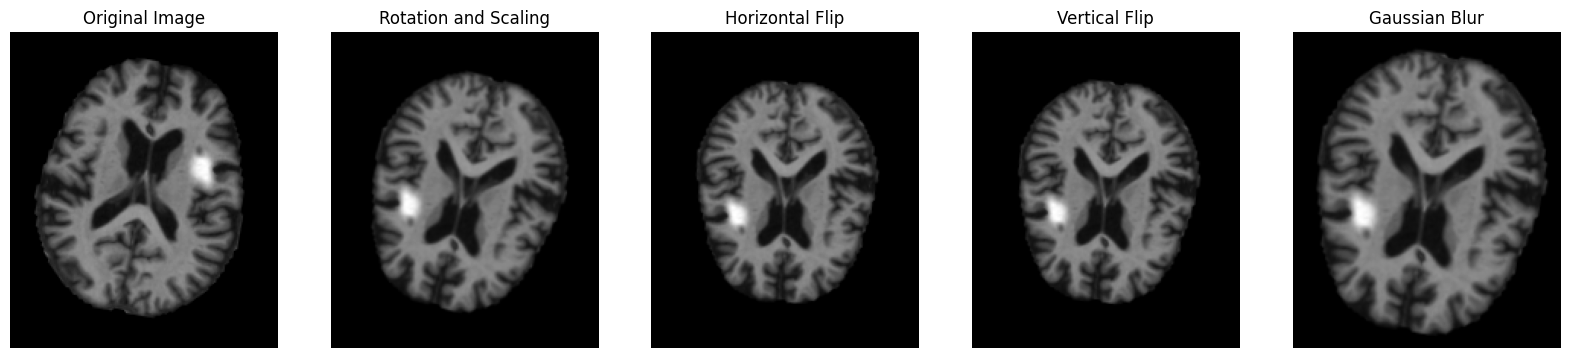

In [ ]:
for image_path in image_paths:
    original_image = np.array(Image.open(image_path).convert('L')) / 255.0
    augmented_images = augment_image(original_image, num_augmentations=4)

    # Display both the original and augmented images with individual headings
    all_images = [original_image] + augmented_images
    all_headings = ['Original Image'] + ['Rotation and Scaling', 'Horizontal Flip', 'Vertical Flip', 'Gaussian Blur']

    display_individual_images(all_images, all_headings, figsize=(20, 5))

Truncation Comparison

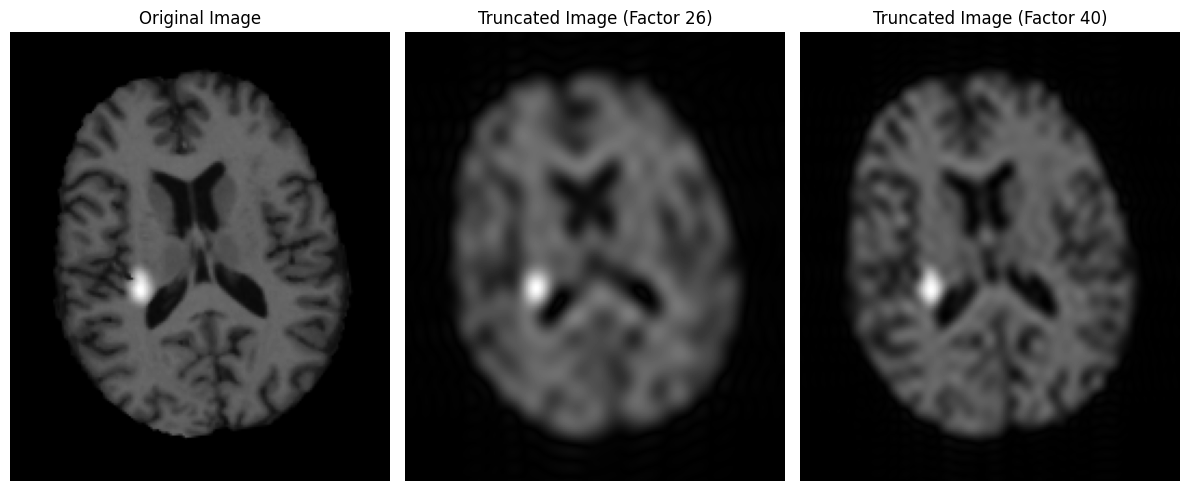

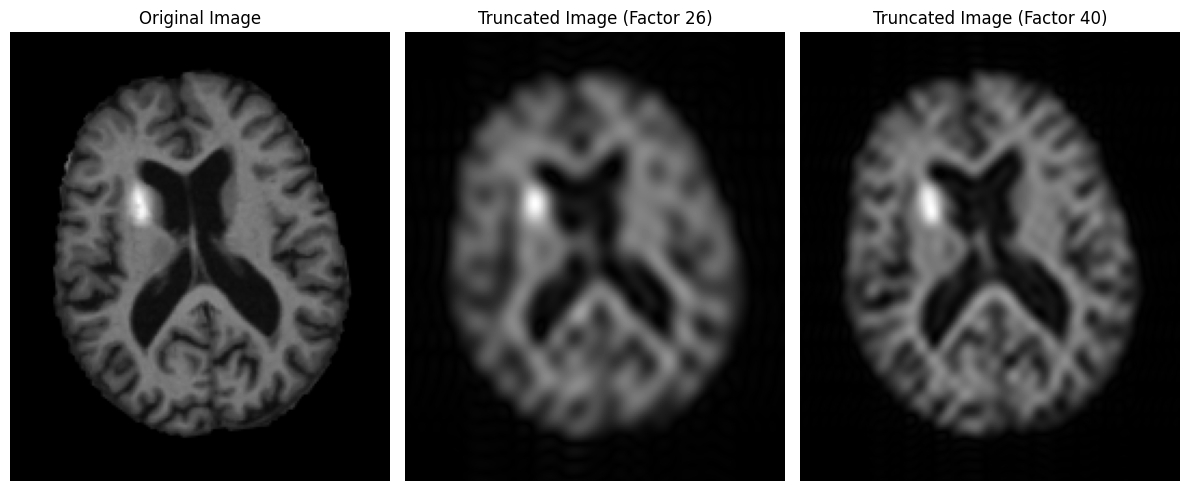

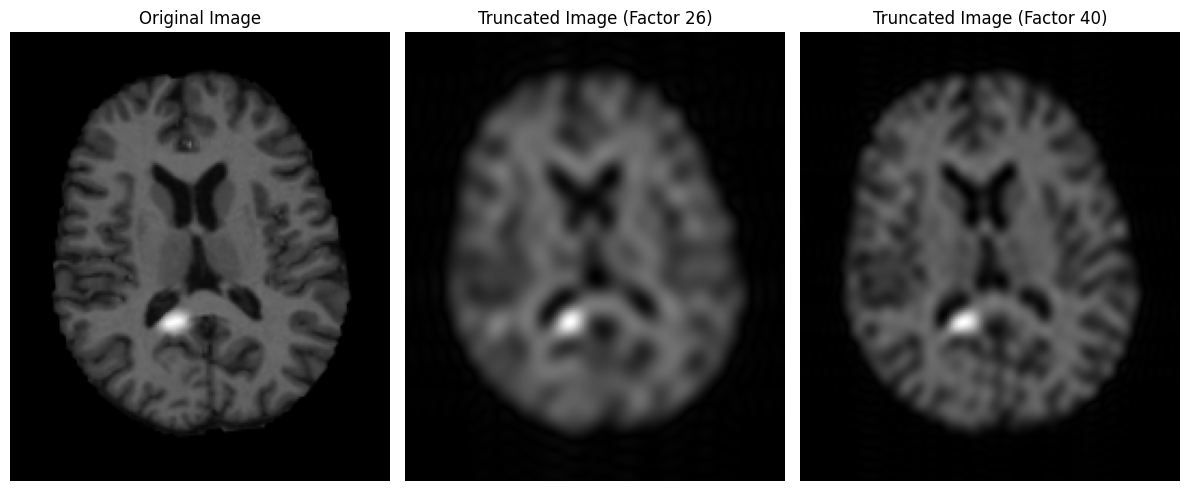

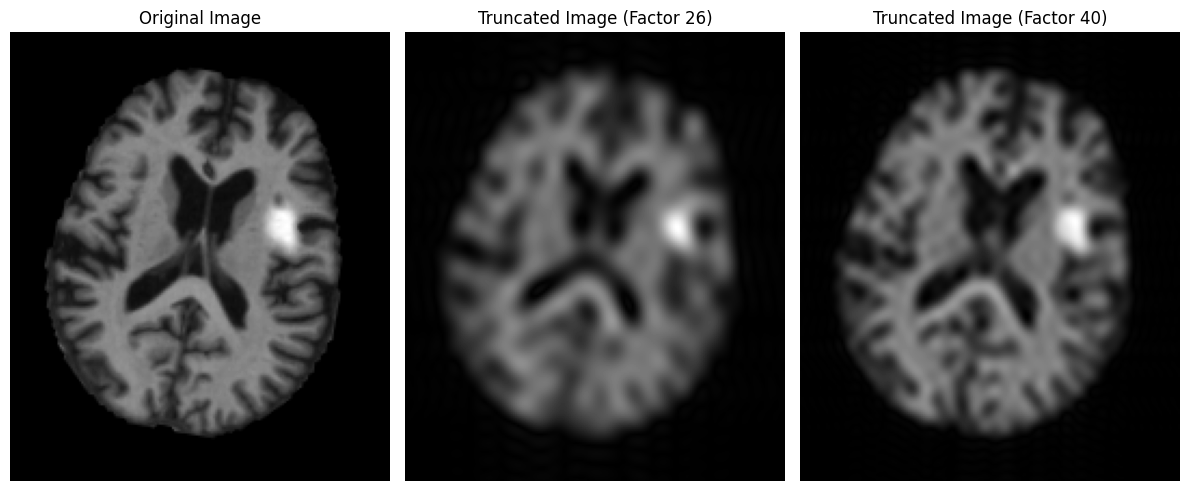

In [ ]:
# Loop through all images for comparison
for selected_image in all_original_images:
    # Two different truncation factors for comparison
    truncation_factors = [26, 40]

    # Display the comparison images
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(selected_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    for i, factor in enumerate(truncation_factors):
        plt.subplot(1, 3, i + 2)
        truncated_image = k_space_truncation(selected_image, factor)
        plt.imshow(truncated_image, cmap='gray')
        plt.title(f'Truncated Image (Factor {factor})')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

K-Space Comparison

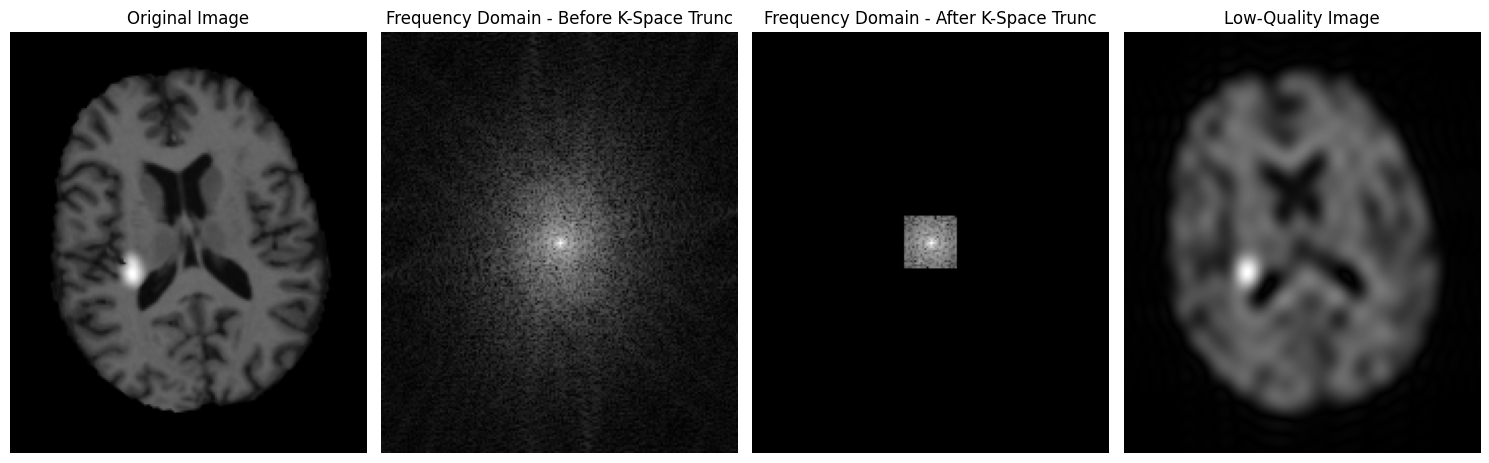

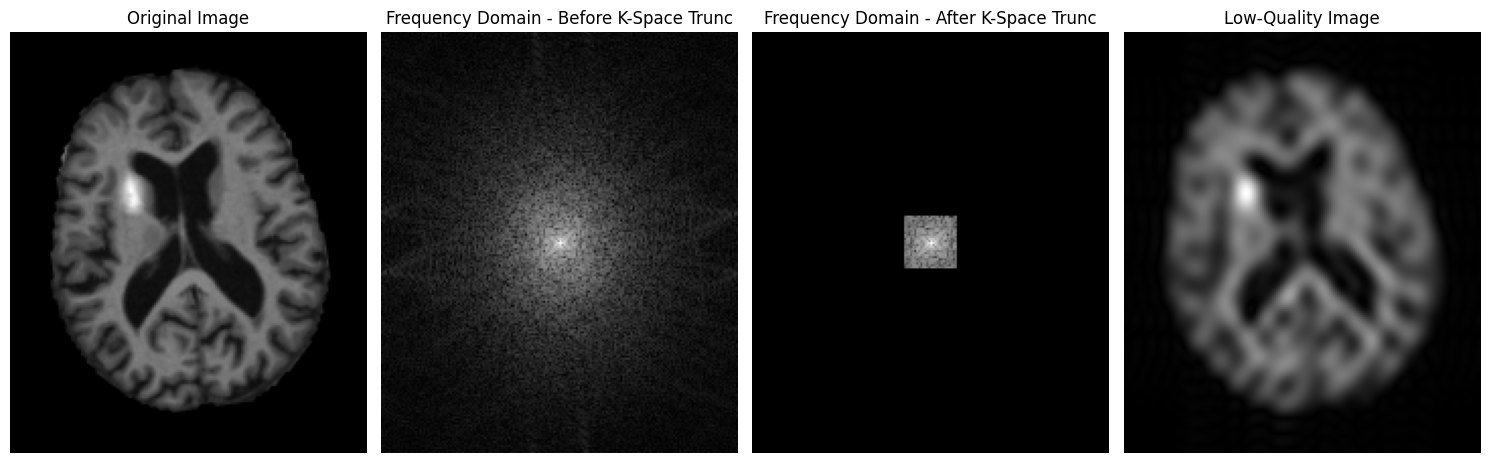

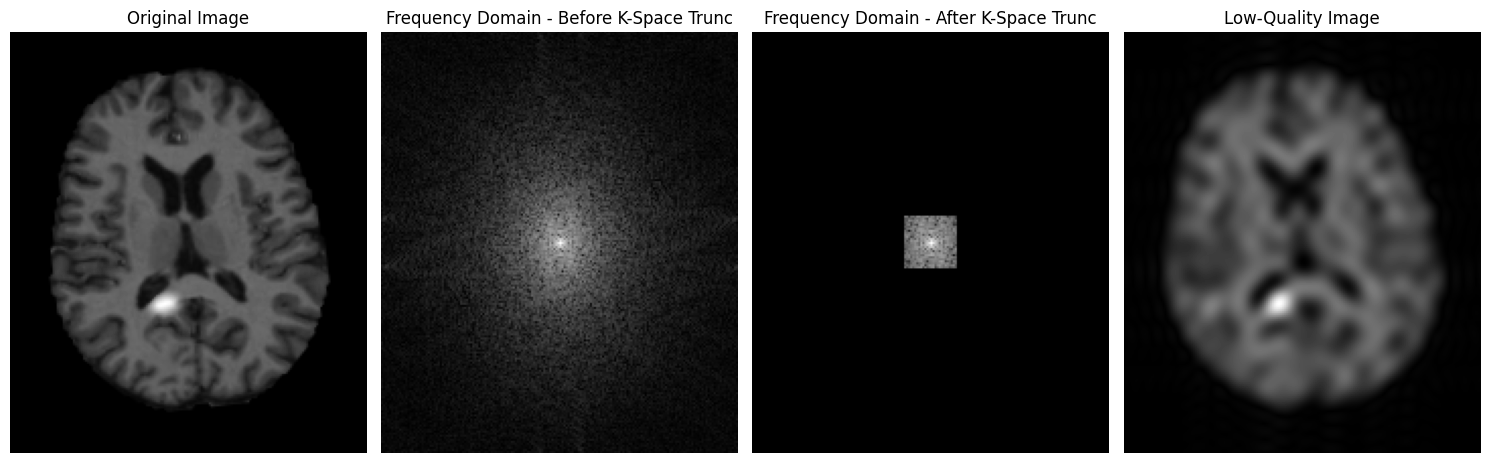

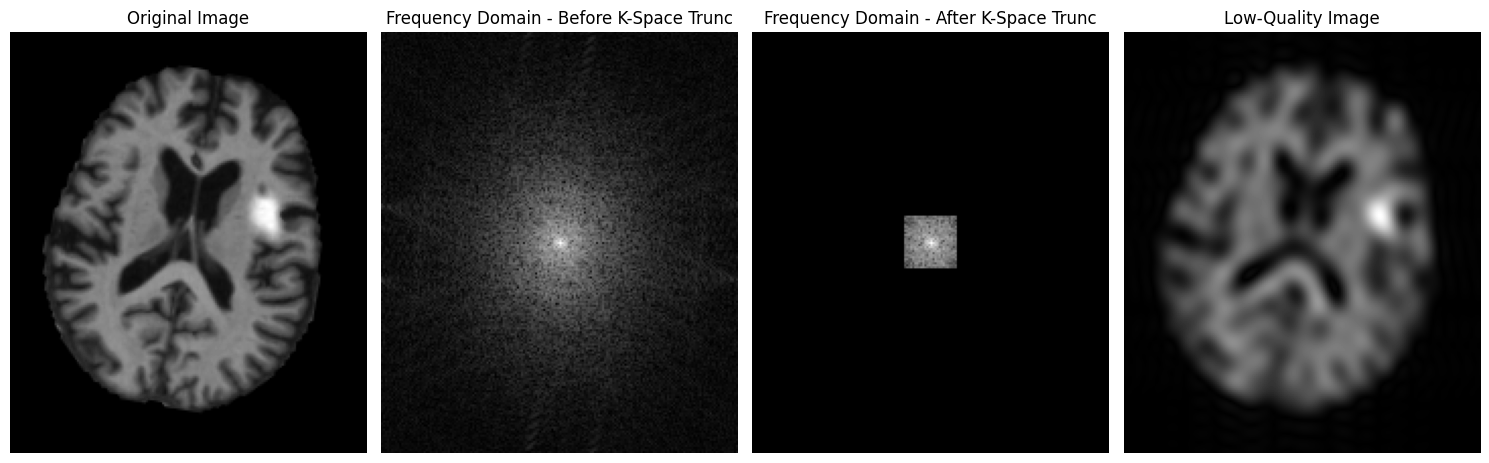

In [ ]:
# Loop through all images for frequency domain transformation and visualization
for original_image in all_original_images:
    # Convert to frequency domain
    fft_image = fftshift(fft2(original_image))

    # Display the original image, frequency domain, and low-quality image
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Frequency Domain - Before K-Space Truncation
    plt.subplot(1, 4, 2)
    plt.imshow(np.log(np.abs(fft_image) + 1), cmap='gray')
    plt.title('Frequency Domain - Before K-Space Trunc')
    plt.axis('off')

    # Create a mask for k-space truncation
    mask = np.zeros_like(fft_image)
    center_x, center_y = mask.shape[0] // 2, mask.shape[1] // 2
    truncation_factor = 26  # Adjust this value as needed
    mask[center_x-truncation_factor//2:center_x+truncation_factor//2,
         center_y-truncation_factor//2:center_y+truncation_factor//2] = 1

    # Apply the mask
    truncated_fft = fft_image * mask

    # Display the masked frequency domain
    plt.subplot(1, 4, 3)
    plt.imshow(np.log(np.abs(truncated_fft) + 1), cmap='gray')
    plt.title('Frequency Domain - After K-Space Trunc')
    plt.axis('off')

    # Apply the inverse FFT
    truncated_image = np.abs(ifft2(fftshift(truncated_fft)))

    # Low-Quality Image - After K-Space Truncation
    plt.subplot(1, 4, 4)
    plt.imshow(truncated_image, cmap='gray')
    plt.title('Low-Quality Image')
    plt.axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()

    plt.show()

Guassian Noise Comparison

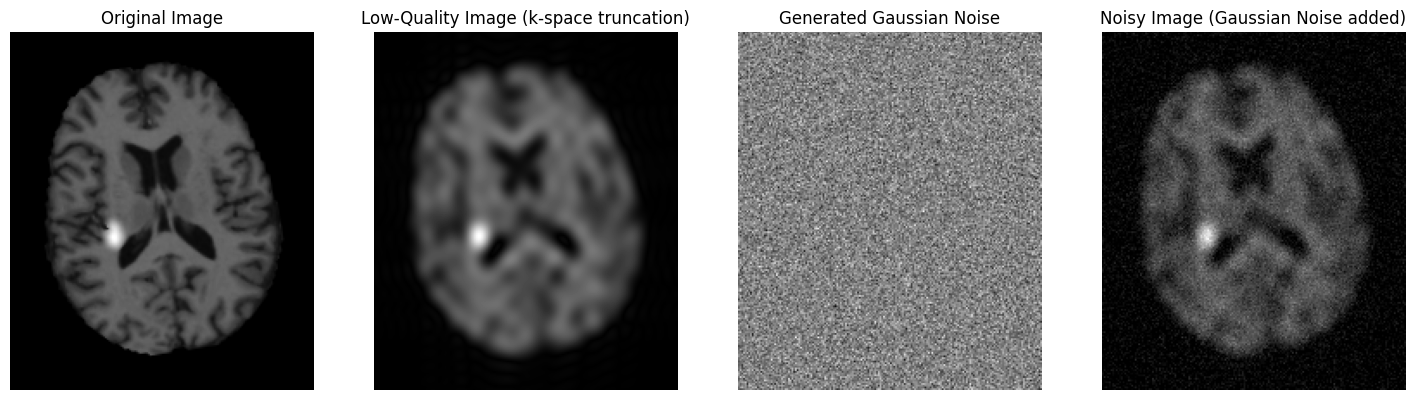

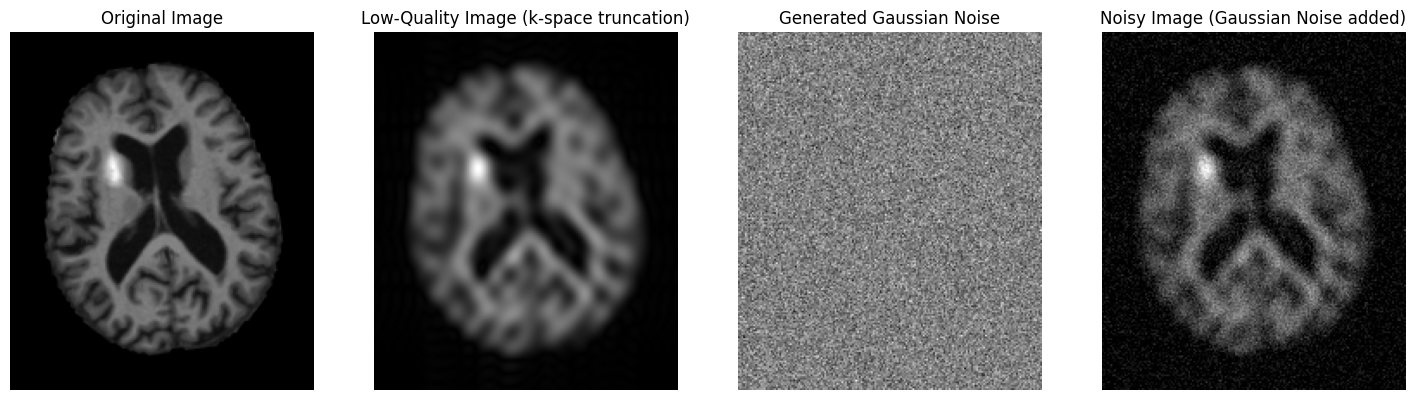

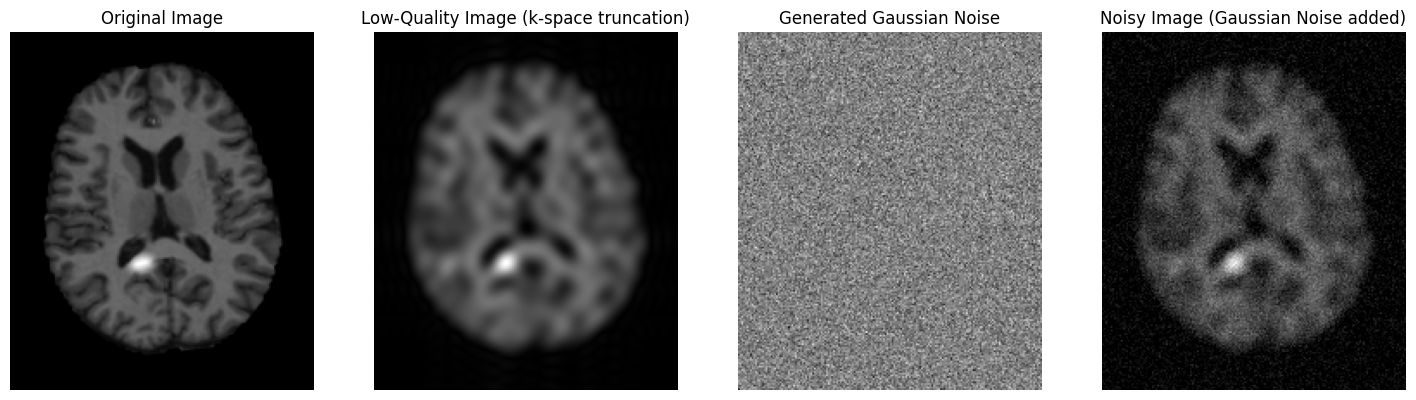

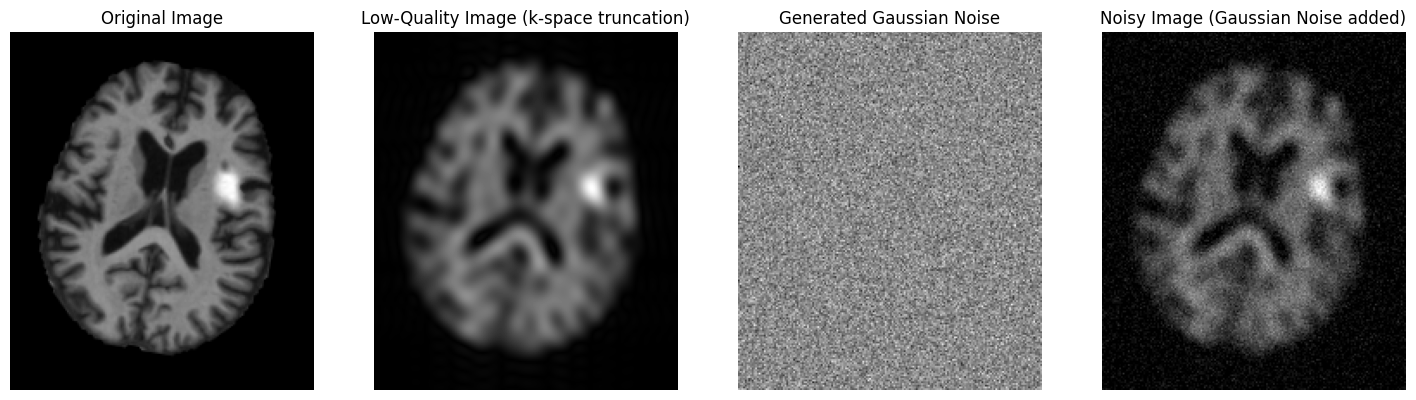

In [ ]:
# Process each input image
for i, image_path in enumerate(image_paths):
    # Load the original image
    original_image = np.array(Image.open(image_path).convert('L')) / 255.0

    # Perform k-space truncation
    truncation_factor = 26
    low_quality_image = k_space_truncation(original_image, truncation_factor)

    # Generate Gaussian noise
    mean = 0
    std_dev = 0.05
    gaussian_noise = np.random.normal(mean, std_dev, low_quality_image.shape)

    # Add Gaussian noise to the low-quality image
    noisy_image = np.clip(low_quality_image + gaussian_noise, 0, 1)

    # Display the images
    plt.figure(figsize=(18, 6))

    # Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Low-Quality Image (k-space truncation)
    plt.subplot(1, 4, 2)
    plt.imshow(low_quality_image, cmap='gray')
    plt.title('Low-Quality Image (k-space truncation)')
    plt.axis('off')

    # Gaussian Noise
    plt.subplot(1, 4, 3)
    plt.imshow(gaussian_noise, cmap='gray')
    plt.title('Generated Gaussian Noise')
    plt.axis('off')

    # Noisy Image (Gaussian Noise added)
    plt.subplot(1, 4, 4)
    plt.imshow(noisy_image, cmap='gray')
    plt.title('Noisy Image (Gaussian Noise added)')
    plt.axis('off')

    plt.show()

Salt and Pepper Noise Comparison

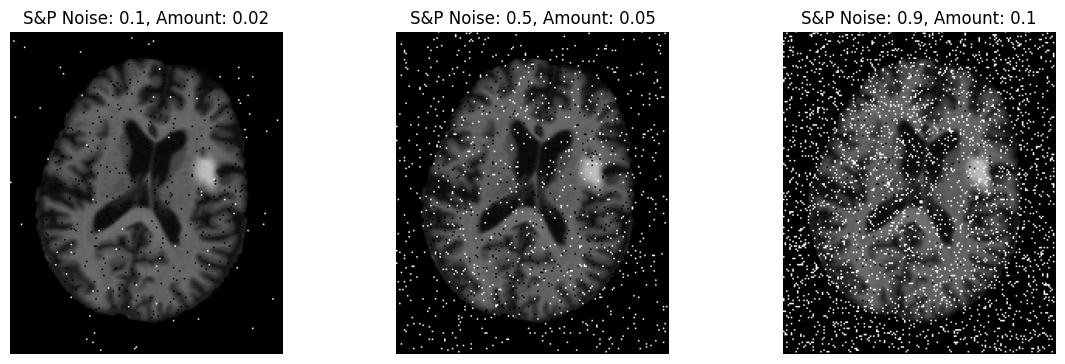

In [ ]:
# Create a figure with specified size
fig = plt.figure(figsize=(12, 4))

# Display the original image
plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Display images with different levels of salt-and-pepper noise
salt_pepper_ratios = [0.1, 0.5, 0.9]
amounts = [0.02, 0.05, 0.1]

for i, (salt_pepper_ratio, amount) in enumerate(zip(salt_pepper_ratios, amounts), 2):
    noisy_image = add_salt_and_pepper_noise(original_image, salt_pepper_ratio, amount)
    plt.subplot(1, 3, i - 1)
    plt.imshow(noisy_image, cmap='gray')
    plt.title(f'S&P Noise: {salt_pepper_ratio}, Amount: {amount}')
    plt.axis('off')

# Adjust layout to include space between subplots
plt.tight_layout(pad=2.0)
plt.show()

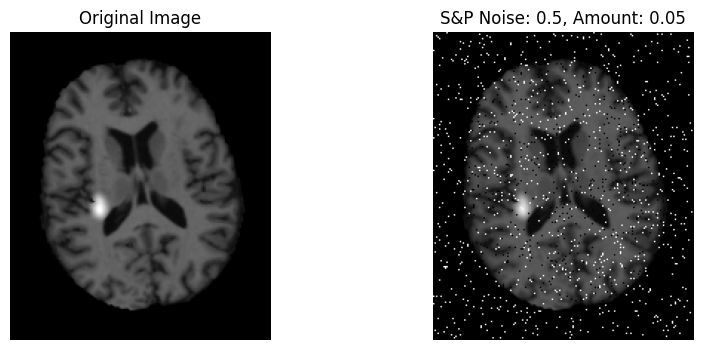

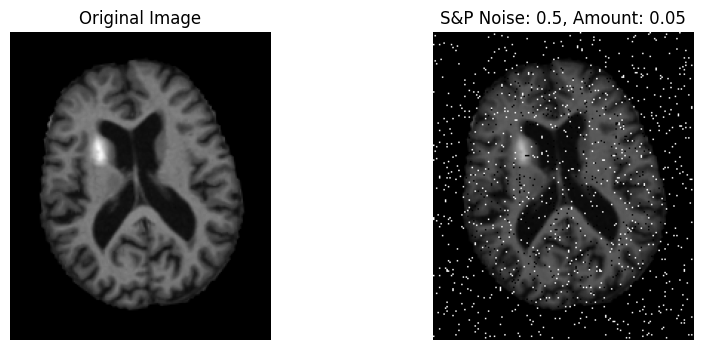

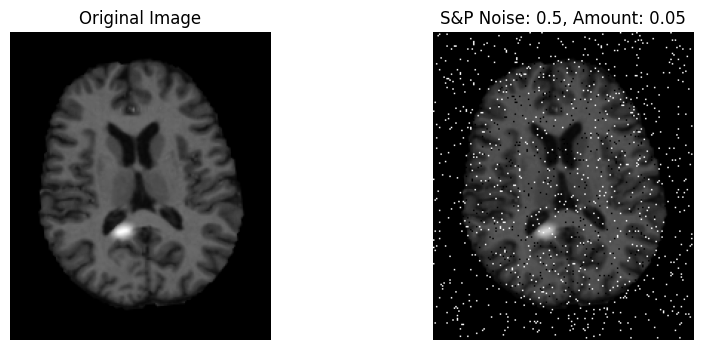

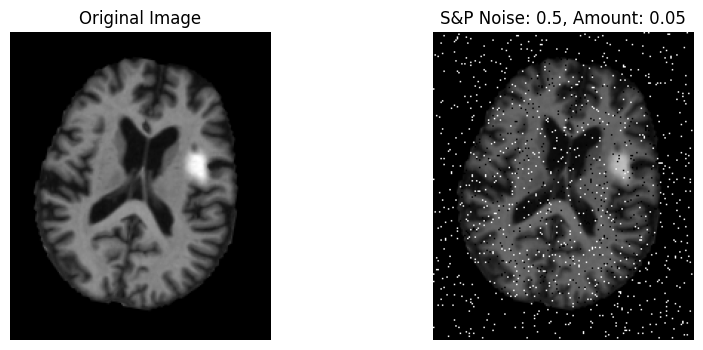

In [ ]:
for original_image in all_original_images:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Display the original image
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Display the image with salt-and-pepper noise
    salt_pepper_ratio = 0.5
    amount = 0.05
    noisy_image = add_salt_and_pepper_noise(original_image, salt_pepper_ratio, amount)
    axes[1].imshow(noisy_image, cmap='gray')
    axes[1].set_title(f'S&P Noise: {salt_pepper_ratio}, Amount: {amount}')
    axes[1].axis('off')

    plt.show()